In [13]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [14]:
dsA = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionA_mixed.zarr')
dsB = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionB_mixed.zarr')

lonsa, latsa = np.meshgrid(dsA.x0.values, dsA.y0.values)
lonsb, latsb = np.meshgrid(dsB.x0.values, dsB.y0.values)

In [15]:
ds1 = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/Raw_eul_lag_surf_vels.zarr')

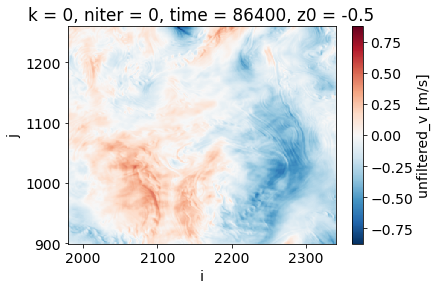

In [16]:
ds1.unfiltered_v.isel(time=1, i=slice(900,-900),j=slice(900,-900)).plot(x='i')

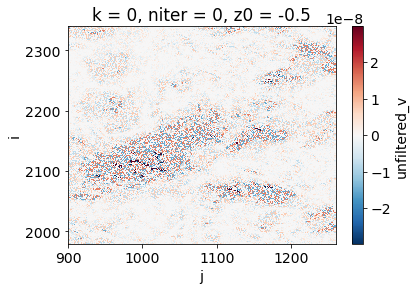

In [17]:
(ds1.unfiltered_v.isel(time=60, i=slice(900,-900),j=slice(900,-900))-dsA.unfiltered_v.isel(time=60)).plot()

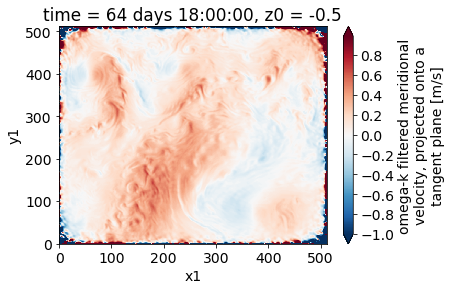

In [24]:
(dsA.wnfiltered_v.isel(time=60)).plot(levels=np.arange(-1,1,0.01))

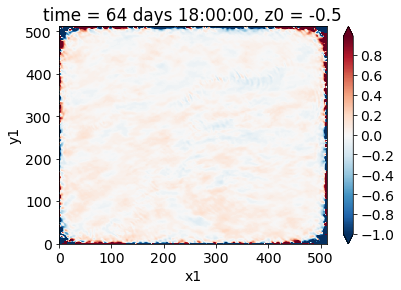

In [23]:
(dsA.wnfiltered_v.isel(time=60)-dsA.unfiltered_v_tp.isel(time=60)).plot(levels=np.arange(-1,1,0.01))

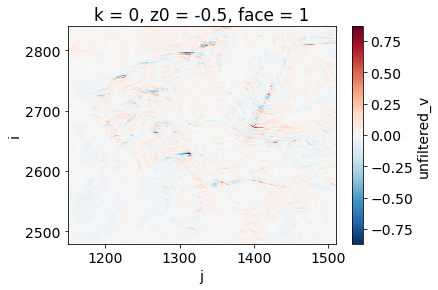

In [49]:
(ds1.unfiltered_v.isel(time=1, i=slice(900+500,-900+500),j=slice(900+250,-900+250))-dsB.unfiltered_v.isel(time=1)).plot()

In [12]:
DXG_array = xr.DataArray(DXG.reshape(2160,2160),dims=['y0','x0'])
dxgi=DXG_array.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb))

DYG_array = xr.DataArray(DYG.reshape(2160,2160),dims=['y0','x0'])
dygi=DYG_array.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb))

NameError: name 'DXG' is not defined

In [3]:
def target_area_def_a(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def target_area_def_b(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =17,40#center_point.x0.values.item(),-center_point.y0.values.item()#region b:3,32 # region c: 17,40
    #region a: center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 0, 1))

def ufunc_resample_a(data):
    target_def = target_area_def_a(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsa, lats=-latsa)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

def ufunc_resample_b(data):
    target_def = target_area_def_a(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsb, lats=-latsb)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

In [20]:
x_resampleda = ufunc_resample_a((dsA.x0*xr.ones_like(dsA.unfiltered_u)).swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).isel(time=slice(0,10)).load().T)
y_resampleda = ufunc_resample_a((dsA.y0*xr.ones_like(dsA.unfiltered_u)).swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).isel(time=slice(0,10)).load().T)

x_resampledb = ufunc_resample_b((dsB.x0*xr.ones_like(dsB.unfiltered_u)).swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).isel(time=slice(0,10)).load().T)
y_resampledb = ufunc_resample_b((dsB.y0*xr.ones_like(dsB.unfiltered_u)).swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).isel(time=slice(0,10)).load().T)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [4]:
u_resampled_unfilta = ufunc_resample_a(dsA.unfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_unfilta = ufunc_resample_a(dsA.unfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
ssh_resampled_unfilta = ufunc_resample_a(dsA.unfiltered_ssh.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_lagfilta = ufunc_resample_a(dsA.lagfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_lagfilta = ufunc_resample_a(dsA.lagfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
ssh_resampled_lagfilta = ufunc_resample_a(dsA.lagfiltered_ssh.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_eulfilta = ufunc_resample_a(dsA.eulfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_eulfilta = ufunc_resample_a(dsA.eulfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
ssh_resampled_eulfilta = ufunc_resample_a(dsA.eulfiltered_ssh.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [5]:
u_resampled_unfiltb = ufunc_resample_b(dsB.unfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_unfiltb = ufunc_resample_b(dsB.unfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
ssh_resampled_unfiltb = ufunc_resample_b(dsB.unfiltered_ssh.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_lagfiltb = ufunc_resample_b(dsB.lagfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_lagfiltb = ufunc_resample_b(dsB.lagfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
ssh_resampled_lagfiltb = ufunc_resample_b(dsB.lagfiltered_ssh.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_eulfiltb = ufunc_resample_b(dsB.eulfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_eulfiltb = ufunc_resample_b(dsB.eulfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
ssh_resampled_eulfiltb = ufunc_resample_b(dsB.eulfiltered_ssh.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [24]:
tangrida = Grid(u_resampled_unfilta, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

tangridb = Grid(u_resampled_unfiltb, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})


In [28]:
fa = 2*2*np.pi/24/3600*np.sin(y_resampleda.isel(time=0)*np.pi/180)
fb = 2*2*np.pi/24/3600*np.sin(y_resampledb.isel(time=0)*np.pi/180)
g=9.81
#tangrid.diff(eta_resampled_unfilt,'X')
u_ga = (-g/fa*tangrida.interp(tangrida.diff(ssh_resampled_unfilta,'Y'),'Y'))/1000
v_ga = (g/fa*tangrida.interp(tangrida.diff(ssh_resampled_unfilta,'X'),'X'))/1000

u_gb = (-g/fb*tangridb.interp(tangridb.diff(ssh_resampled_unfiltb,'Y'),'Y'))/1000
v_gb = (g/fb*tangridb.interp(tangridb.diff(ssh_resampled_unfiltb,'X'),'X'))/1000

u_ga_eul = (-g/fa*tangrida.interp(tangrida.diff(ssh_resampled_eulfilta,'Y'),'Y'))/1000
v_ga_eul = (g/fa*tangrida.interp(tangrida.diff(ssh_resampled_eulfilta,'X'),'X'))/1000

u_gb_eul = (-g/fb*tangridb.interp(tangridb.diff(ssh_resampled_eulfiltb,'Y'),'Y'))/1000
v_gb_eul = (g/fb*tangridb.interp(tangridb.diff(ssh_resampled_eulfiltb,'X'),'X'))/1000

u_ga_lag = (-g/fa*tangrida.interp(tangrida.diff(ssh_resampled_lagfilta,'Y'),'Y'))/1000
v_ga_lag = (g/fa*tangrida.interp(tangrida.diff(ssh_resampled_lagfilta,'X'),'X'))/1000

u_gb_lag = (-g/fb*tangridb.interp(tangridb.diff(ssh_resampled_lagfiltb,'Y'),'Y'))/1000
v_gb_lag = (g/fb*tangridb.interp(tangridb.diff(ssh_resampled_lagfiltb,'X'),'X'))/1000

u_ga_wn = (-g/fa*tangrida.interp(tangrida.diff(dsA.wnfiltered_ssh,'Y'),'Y'))/1000
v_ga_wn = (g/fa*tangrida.interp(tangrida.diff(dsA.wnfiltered_ssh,'X'),'X'))/1000

u_gb_wn = (-g/fb*tangridb.interp(tangridb.diff(dsB.wnfiltered_ssh,'Y'),'Y'))/1000
v_gb_wn = (g/fb*tangridb.interp(tangridb.diff(dsB.wnfiltered_ssh,'X'),'X'))/1000

In [32]:
dsA

<xarray.Dataset>
Dimensions:          (i: 360, i_g: 360, j: 360, j_g: 360, time: 70, x1: 512, y1: 512)
Coordinates: (12/22)
    DX               (x1) float64 dask.array<chunksize=(312,), meta=np.ndarray>
    DXC              (j, i_g) float32 dask.array<chunksize=(360, 360), meta=np.ndarray>
    DXG              (j_g, i) float32 dask.array<chunksize=(360, 360), meta=np.ndarray>
    DY               (y1) float64 dask.array<chunksize=(312,), meta=np.ndarray>
    DYC              (j_g, i) float32 dask.array<chunksize=(360, 360), meta=np.ndarray>
    DYG              (j, i_g) float32 dask.array<chunksize=(360, 360), meta=np.ndarray>
    ...               ...
  * time             (time) timedelta64[ns] 4 days 19:00:00 ... 73 days 19:00:00
    x                (j, i) float32 dask.array<chunksize=(360, 360), meta=np.ndarray>
    x0               (i) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    y                (j, i) float32 dask.array<chunksize=(360, 360), meta=np.ndarray>
    y0               (j) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    z0               float64 ...
Dimensions without coordinates: i_g, j_g, x1, y1
Data variables: (12/13)
    eulfiltered_ssh  (time, j, i) float64 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    eulfiltered_u    (time, j, i) float64 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    eulfiltered_v    (time, j, i) float64 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    frontogenesis    (time, j, i) float64 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    lagfiltered_ssh  (time, i, j) float64 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    lagfiltered_u    (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    ...               ...
    unfiltered_ssh   (time, j, i) float32 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    unfiltered_u     (time, j, i) float32 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    unfiltered_v     (time, j, i) float32 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    wnfiltered_ssh   (time, y1, x1) float64 dask.array<chunksize=(1, 312, 312), meta=np.ndarray>
    wnfiltered_u     (time, y1, x1) float64 dask.array<chunksize=(1, 312, 312), meta=np.ndarray>
    wnfiltered_v     (time, y1, x1) float64 dask.array<chunksize=(1, 312, 312), meta=np.ndarray>

In [34]:
last_time = 70
geostrophic_speeda = (u_ga.isel(time=slice(0,last_time))**2 
                    + v_ga.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speeda_eul = (u_ga_eul.isel(time=slice(0,last_time))**2 
                    + v_ga_eul.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speeda_lag = (u_ga_lag.isel(time=slice(0,last_time))**2 
                    + v_ga_lag.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speeda_wn = (u_ga_wn.isel(time=slice(0,last_time))**2 
                    + v_ga_wn.isel(time=slice(0,last_time))**2)**0.5

wnfiltered_speeda = (dsA.wnfiltered_u.isel(time=slice(0,last_time))**2 
                    + dsA.wnfiltered_v.isel(time=slice(0,last_time))**2)**0.5
filtered_speeda = (u_resampled_lagfilta.isel(time=slice(0,last_time))**2 
                    + v_resampled_lagfilta.isel(time=slice(0,last_time))**2)**0.5
eulfiltered_speeda = (u_resampled_eulfilta.isel(time=slice(0,last_time))**2 
                    + v_resampled_eulfilta.isel(time=slice(0,last_time))**2)**0.5
unfiltered_speeda = (u_resampled_unfilta.isel(time=slice(0,last_time))**2 
                    + v_resampled_unfilta.isel(time=slice(0,last_time))**2)**0.5


geostrophic_speedb = (u_gb.isel(time=slice(0,last_time))**2 
                    + v_gb.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speedb_eul = (u_gb_eul.isel(time=slice(0,last_time))**2 
                    + v_gb_eul.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speedb_lag = (u_gb_lag.isel(time=slice(0,last_time))**2 
                    + v_gb_lag.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speedb_wn = (u_gb_wn.isel(time=slice(0,last_time))**2 
                    + v_gb_wn.isel(time=slice(0,last_time))**2)**0.5

wnfiltered_speedb = (dsB.wnfiltered_u.isel(time=slice(0,last_time))**2 
                    + dsB.wnfiltered_v.isel(time=slice(0,last_time))**2)**0.5
filtered_speedb = (u_resampled_lagfiltb.isel(time=slice(0,last_time))**2 
                    + v_resampled_lagfiltb.isel(time=slice(0,last_time))**2)**0.5
eulfiltered_speedb = (u_resampled_eulfiltb.isel(time=slice(0,last_time))**2 
                    + v_resampled_eulfiltb.isel(time=slice(0,last_time))**2)**0.5
unfiltered_speedb = (u_resampled_unfiltb.isel(time=slice(0,last_time))**2 
                    + v_resampled_unfiltb.isel(time=slice(0,last_time))**2)**0.5

In [35]:
rms_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                   /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rms_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                 /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rms_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
            /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rms_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                   /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rms_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                   /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rms_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                 /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rms_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rms_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmseul_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmseul_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmseul_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmseul_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmseul_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmseul_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmseul_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmseul_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()


rmslag_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmslag_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmslag_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmslag_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmslag_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmslag_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmslag_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmslag_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmswn_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmswn_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmswn_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmswn_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmswn_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmswn_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmswn_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmswn_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/reductions.py:639: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/reductions.py:639: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/reductions.py:639: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/reductions.py:639: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/reductions.py:639: Run

In [36]:
etau_au = rms_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_ao = rms_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_al = rms_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_aw = rms_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etau_bu = rms_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_bo = rms_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_bl = rms_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_bw = rms_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etae_au = rmseul_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_ao = rmseul_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_al = rmseul_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_aw = rmseul_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etae_bu = rmseul_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_bo = rmseul_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_bl = rmseul_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_bw = rmseul_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etal_au = rmslag_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_ao = rmslag_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_al = rmslag_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_aw = rmslag_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etal_bu = rmslag_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_bo = rmslag_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_bl = rmslag_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_bw = rmslag_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etaw_au = rmswn_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_ao = rmswn_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_al = rmswn_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_aw = rmswn_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etaw_bu = rmswn_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_bo = rmswn_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_bl = rmswn_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_bw = rmswn_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

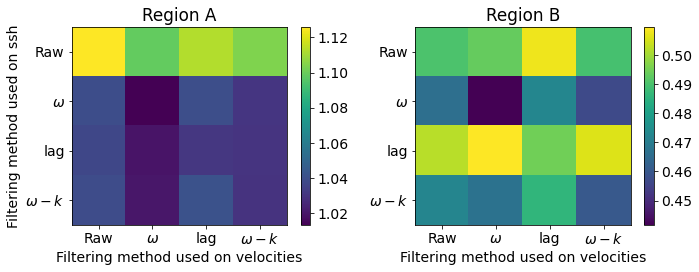

In [37]:
gleckler_list_a = np.array([[etau_au, etau_ao, etau_al, etau_aw],[etae_au, etae_ao, etae_al, etae_aw],
                            [etal_au, etal_ao, etal_al, etal_aw],[etaw_au, etaw_ao, etaw_al, etaw_aw]])

gleckler_list_b = np.array([[etau_bu, etau_bo, etau_bl, etau_bw],[etae_bu, etae_bo, etae_bl, etae_bw],
                           [etal_bu, etal_bo, etal_bl, etal_bw],[etaw_bu, etaw_bo, etaw_bl, etaw_bw]])


plt.figure(figsize=(10,4))
plt.subplot(121)
cs=plt.pcolor(gleckler_list_a)
plt.colorbar(cs)
ax = plt.gca()
ax.invert_yaxis()

ax.set_xticks(np.arange(gleckler_list_a.shape[1])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(gleckler_list_a.shape[0])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']#, '$\omega-k$']
ax.set_yticklabels(labels)
plt.xlabel('Filtering method used on velocities')
plt.ylabel('Filtering method used on ssh')
plt.title('Region A')

plt.subplot(122)
cs = plt.pcolor(gleckler_list_b)
plt.colorbar(cs)
ax = plt.gca()
ax.invert_yaxis()

ax.set_xticks(np.arange(gleckler_list_b.shape[1])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(gleckler_list_b.shape[0])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']#, '$\omega-k$']
ax.set_yticklabels(labels)
plt.xlabel('Filtering method used on velocities')
#plt.ylabel('Filtering method used on ssh')
plt.title('Region B')

plt.subplots_adjust(wspace=0.3)

plt.tight_layout()

fig=plt.gcf()
fig.savefig('geostrophy_gleckler.png')